Conda env: `aops_mathbert`

In [1]:
import numpy as np
import pandas as pd
from time import perf_counter

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import seaborn as sns
from official.nlp import optimization  # to create AdamW optimizer

from transformers import BertTokenizer, TFBertModel
from transformers import AutoTokenizer

from utils.utils_for_regression import calculate_descriptive_statistics
from utils.utils_for_regression import mse_tf, rmse_tf, mae_tf, r2_score_tf
from utils.util_write_training_result import append_training_result


def compare_actual_and_predict_values(model, tokenized_list_of_texts, list_of_texts, list_of_actual):
    predicted = []
    for i in range(len(tokenized_list_of_texts[0])):
        temp = model([
            [tf.expand_dims(tokenized_list_of_texts[0][i], axis=0)], 
            [tf.expand_dims(tokenized_list_of_texts[1][i], axis=0)], 
            [tf.expand_dims(tokenized_list_of_texts[2][i], axis=0)]
        ])
        temp = temp.numpy().flatten()[0]
        predicted.append(temp)
    predicted = np.array(predicted)
    list_of_actual = np.array(list_of_actual)

    for i in range(len(list_of_texts)):
        print(f"{str(i+1):>2s}. {list_of_texts[i]}")
        print(f"    Actual   Predicted")
        print(f"    {list_of_actual[i]:.3f}    {predicted[i]:.3f}")
        print()
        
    pd.set_option('display.max_rows', 500)
    display(pd.DataFrame({
        'actual': list_of_actual,
        'predicted': predicted
    }))

def model_evaluate_and_analytics(model, tokenized_list_of_texts, list_of_actual, suptitle: str):
    predicted = []
    for i in range(len(tokenized_list_of_texts[0])):
        temp = model([
            [tf.expand_dims(tokenized_list_of_texts[0][i], axis=0)], 
            [tf.expand_dims(tokenized_list_of_texts[1][i], axis=0)], 
            [tf.expand_dims(tokenized_list_of_texts[2][i], axis=0)]
        ])
        temp = temp.numpy().flatten()[0]
        predicted.append(temp)
    predicted = np.array(predicted)
    list_of_actual = np.array(list_of_actual)
    
    stat_actual = calculate_descriptive_statistics(list_of_actual)
    stat_pred = calculate_descriptive_statistics(predicted)
    print(f"           actual              predict")
    print(f"Mean       {stat_actual['mean']}    {stat_pred['mean']}")
    print(f"Variance   {stat_actual['variance']}    {stat_pred['variance']}")
    print(f"STD        {stat_actual['std']}    {stat_pred['std']}")
    print(f"min        {stat_actual['min']}    {stat_pred['min']}")
    print(f"max        {stat_actual['max']}    {stat_pred['max']}")
    print()

    mse_loss = mse_tf(y_true=list_of_actual, y_pred=predicted)
    rmse = rmse_tf(y_true=list_of_actual, y_pred=predicted)
    mae = mae_tf(y_true=list_of_actual, y_pred=predicted)
    r2_score = r2_score_tf(y_true=list_of_actual, y_pred=predicted)
    print(f"loss(mse)         rmse              mae               r2")
    print(f"{mse_loss:.12f}    {rmse:.12f}    {mae:.12f}    {r2_score:.12f}")

    fig, ax = plt.subplots(3, 2, figsize=(16, 14), constrained_layout=True)
    fig.suptitle(f"Data '{suptitle}'")
    plt.subplot(3, 2, (1,2))
    sns.kdeplot(list_of_actual, label='Actual', shade=True, color='blue', linewidth=2)
    sns.kdeplot(predicted, label='Predicted', shade=True, color='red', linewidth=2)
    plt.xlim((-1, 11))
    plt.title('Density Plot of Actual & Predicted Values')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.xlim((-1, 11))
    sns.kdeplot(list_of_actual, label='Actual', shade=True, color='blue', linewidth=2)
    plt.xlabel('Values')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.xlim((-1, 11))
    sns.kdeplot(predicted, label='Predicted', shade=True, color='red', linewidth=2)
    plt.xlabel('Values')
    plt.legend()

    # Scatter plot
    plt.subplot(3, 2, (5, 6))
    plt.scatter(list_of_actual, predicted, color='blue', marker='x', label='Data Points')
    fx_x = np.linspace(0, 10, 100)  # Generate x values for the line
    plt.plot(fx_x, fx_x, color='red', linestyle='--', label='f(x) = x')
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Scatter Plot of Predict & Actual')
    plt.grid(True)
    plt.legend()

    plt.show()

    result = {'mse': mse_loss, 'rmse': rmse, 'mae': mae, 'r2': r2_score}
    return {'model_eval': result}, {'actual': stat_actual}, {'pred': stat_pred}

def tokenize_text(array, max_length=512, return_tensor:bool = False):
    tokenizer = BertTokenizer.from_pretrained('tbs17/MathBERT', output_hidden_states=True)
    tokenized_list = tokenizer(array, padding='max_length', max_length=max_length, truncation=True, return_tensors='tf')
    
    if type(return_tensor) is not bool:
        raise TypeError(f"return_tensor must a boolean. Found return_tensor={type(return_tensor)}")
    if return_tensor is True:
        return tf.data.Dataset.from_tensor_slices((tokenized_list['input_ids'], tokenized_list['attention_mask'], tokenized_list['token_type_ids']))
    if return_tensor is False:
        return tokenized_list['input_ids'], tokenized_list['attention_mask'], tokenized_list['token_type_ids']

# epochs = [10, 15, 20, 25, 30]
# lr     = [1e-5, 2e-5]
epochs = 12
learning_rate = 2e-5
data_type = "imo"
trainable_l1 = True
trainable_l2 = True
trainable_l3 = True
trainable_l4 = True
trainable_l5 = True
trainable_l6 = True
trainable_l7 = True
trainable_l8 = True
trainable_l9 = True
trainable_l10 = False
trainable_l11 = False
trainable_l12 = False


c:\Users\IBDA\.conda\envs\victor_aops_mathbert\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\IBDA\.conda\envs\victor_aops_mathbert\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do no

Prepare & Load Dataset

In [2]:
def load_tokenized_train_val_test_ds(path, batch_size, AUTOTUNE=tf.data.AUTOTUNE):
    df_train = pd.read_csv(f"{path}train.csv")
    df_test = pd.read_csv(f"{path}test.csv")
    df_val = pd.read_csv(f"{path}val.csv")

    train_post_canonical = list(df_train['post_canonical'].values)
    train_score = df_train['score'].values

    test_post_canonical = list(df_test['post_canonical'].values)
    test_score = df_test['score'].values

    val_post_canonical = list(df_val['post_canonical'].values)
    val_score = df_val['score'].values

    tokenized_train = tokenize_text(train_post_canonical, max_length=512, return_tensor=False)
    tokenized_test = tokenize_text(test_post_canonical, max_length=512, return_tensor=False)
    tokenized_val = tokenize_text(val_post_canonical, max_length=512, return_tensor=False)
    
    train_ds = tf.data.Dataset.from_tensor_slices((tokenized_train, train_score))
    test_ds = tf.data.Dataset.from_tensor_slices((tokenized_test, test_score))
    val_ds = tf.data.Dataset.from_tensor_slices((tokenized_val, val_score))
    
    train_ds = train_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

    ds = {
        'train': {'X': train_post_canonical,'y': train_score},
        'test': {'X': test_post_canonical,'y': test_score},
        'val': {'X': val_post_canonical,'y': val_score},
    }
    ds_tok = {
        'train': {'X': tokenized_train,'y': train_score},
        'test': {'X': tokenized_test,'y': test_score},
        'val': {'X': tokenized_val,'y': val_score},
    }
    
    return train_ds, val_ds, test_ds, ds, ds_tok

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16

dt_mapped = {'imo': "../data/regression/imo/", 'combined_all': "../data/regression/"}
train_ds, val_ds, test_ds, datasets, datasets_tokenized = load_tokenized_train_val_test_ds(dt_mapped[data_type], batch_size=batch_size, AUTOTUNE=AUTOTUNE)


In [3]:
class MathBertRegressorModel:
    def __init__(self, max_length=512) -> None:
        self.max_length = max_length
        
        self.model = self.build_model()
        
        self.learning_rate = None
        self.train_ds = None
        self.validation_data = None
        self.epochs = None
        
        self.history = None
        self.training_time = None

    def build_model(self):
        input_ids_layer = tf.keras.Input(shape=(self.max_length,), dtype=tf.int32, name='input_ids_layer')
        attention_mask_layer = tf.keras.Input(shape=(self.max_length,), dtype=tf.int32, name='attention_mask_layer')
        token_type_ids_layer = tf.keras.Input(shape=(self.max_length,), dtype=tf.int32, name='token_type_ids_layer')
        inputs = [input_ids_layer, attention_mask_layer, token_type_ids_layer]
        
        encoder = TFBertModel.from_pretrained("tbs17/MathBERT", from_pt=True)
        # encoder.trainable = False
        
        encoder.bert.encoder.layer[0].trainable = trainable_l1
        encoder.bert.encoder.layer[1].trainable = trainable_l2
        encoder.bert.encoder.layer[2].trainable = trainable_l3
        encoder.bert.encoder.layer[3].trainable = trainable_l4
        encoder.bert.encoder.layer[4].trainable = trainable_l5
        encoder.bert.encoder.layer[5].trainable = trainable_l6
        encoder.bert.encoder.layer[6].trainable = trainable_l7
        encoder.bert.encoder.layer[7].trainable = trainable_l8
        encoder.bert.encoder.layer[8].trainable = trainable_l9
        encoder.bert.encoder.layer[9].trainable = trainable_l10
        encoder.bert.encoder.layer[10].trainable = trainable_l11
        encoder.bert.encoder.layer[11].trainable = trainable_l12
        print()
        for i in range(len(encoder.bert.encoder.layer)):
            print(f"bert.encoder.layer[{str(i+1)}].trainable: {encoder.bert.encoder.layer[i].trainable}")
        
        encoded_text = encoder(input_ids=input_ids_layer, attention_mask=attention_mask_layer, token_type_ids=token_type_ids_layer)
        pooler_output = encoded_text['pooler_output']  # Output -> dict.keys(['last_hidden_state', 'pooler_output'])
        
        net = tf.keras.layers.Dropout(0.1)(pooler_output)
        net = tf.keras.layers.Dense(1, activation='linear')(net)
    
        return tf.keras.Model(inputs=inputs, outputs=net)
    
    def compile_model(self, train_ds, validation_data, epochs, learning_rate, optimizer_type='adamw', loss=tf.keras.losses.mean_squared_error, metrics=['mae']):
        self.train_ds = train_ds
        self.validation_data = validation_data
        self.epochs = epochs
        self.learning_rate = learning_rate
        
        steps_per_epoch = tf.data.experimental.cardinality(self.train_ds).numpy()
        num_train_steps = steps_per_epoch * self.epochs
        optimizer = optimization.create_optimizer(
            init_lr=learning_rate,
            num_train_steps=num_train_steps,
            num_warmup_steps=int(0.1*num_train_steps),
            optimizer_type=optimizer_type
        )
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        self.model.summary(show_trainable=True)

    def train(self):
        print("Start training..")
        start = perf_counter()
        history = self.model.fit(
            self.train_ds, 
            validation_data=self.validation_data, 
            epochs=self.epochs
        )
        end = perf_counter()
        self.training_time = end-start
        print(f"\nTotal training time: {self.training_time:.2f}s")

        self.history = history.history
        return history
    
    def evaluate_test(self, test_ds):
        self.model.evaluate(test_ds)
        
    def plot_training_history_over_time(self, figsize=(16, 6)):
        print(self.history.keys())
        print("Training history over time")
        
        train_loss = self.history['loss']
        train_mae = self.history['mae']

        val_loss = self.history['val_loss']
        val_mae = self.history['val_mae']
        epochs_list = range(1, self.epochs+1)
        
        figure, ax = plt.subplots(1, 2, figsize=figsize, layout="constrained")
        figure.suptitle(f"lr:{self.learning_rate} | epochs:{self.epochs} | data:{data_type}")
        
        # loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs_list, train_loss, 'r', label='Training loss')
        plt.plot(epochs_list, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')

        # mae
        plt.subplot(1, 2, 2)
        plt.plot(epochs_list, train_mae, 'r', label='Training mae')
        plt.plot(epochs_list, val_mae, 'b', label='Validation mae')
        plt.title('Training and validation mae')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend(loc='upper right')

optimizer_type = 'adamw'
loss = tf.keras.losses.mean_squared_error
metrics = ['mae']


In [4]:
mathbert_regressor_model = MathBertRegressorModel()
mathbert_regressor_model.compile_model(
    train_ds, 
    val_ds, 
    epochs=epochs, 
    learning_rate=learning_rate, 
    optimizer_type=optimizer_type, 
    loss=loss, 
    metrics=metrics
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'bert.embeddings.position_ids', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 


bert.encoder.layer[1].trainable: True
bert.encoder.layer[2].trainable: True
bert.encoder.layer[3].trainable: True
bert.encoder.layer[4].trainable: True
bert.encoder.layer[5].trainable: True
bert.encoder.layer[6].trainable: True
bert.encoder.layer[7].trainable: True
bert.encoder.layer[8].trainable: True
bert.encoder.layer[9].trainable: True
bert.encoder.layer[10].trainable: False
bert.encoder.layer[11].trainable: False
bert.encoder.layer[12].trainable: False
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                       

In [5]:
mathbert_regressor_model.train()


Start training..
Epoch 1/12
18/18 [==============================] - 21s 488ms/step - loss: 25.7357 - mae: 4.4191 - val_loss: 4.7495 - val_mae: 1.8027
Epoch 2/12
18/18 [==============================] - 6s 340ms/step - loss: 5.5093 - mae: 1.9009 - val_loss: 5.1909 - val_mae: 1.8473
Epoch 3/12
18/18 [==============================] - 6s 340ms/step - loss: 4.4982 - mae: 1.7551 - val_loss: 4.4606 - val_mae: 1.7254
Epoch 4/12
18/18 [==============================] - 6s 340ms/step - loss: 3.7846 - mae: 1.5946 - val_loss: 4.1347 - val_mae: 1.6901
Epoch 5/12
18/18 [==============================] - 6s 339ms/step - loss: 2.9389 - mae: 1.3790 - val_loss: 3.7611 - val_mae: 1.6110
Epoch 6/12
18/18 [==============================] - 6s 339ms/step - loss: 1.9296 - mae: 1.1074 - val_loss: 3.8708 - val_mae: 1.5918
Epoch 7/12
18/18 [==============================] - 6s 340ms/step - loss: 1.1577 - mae: 0.8432 - val_loss: 4.4100 - val_mae: 1.6980
Epoch 8/12
18/18 [==============================] - 6s 34

In [6]:
mathbert_regressor_model.evaluate_test(test_ds)


5/5 [==============================] - 1s 114ms/step - loss: 7.7939 - mae: 2.3702


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Training history over time


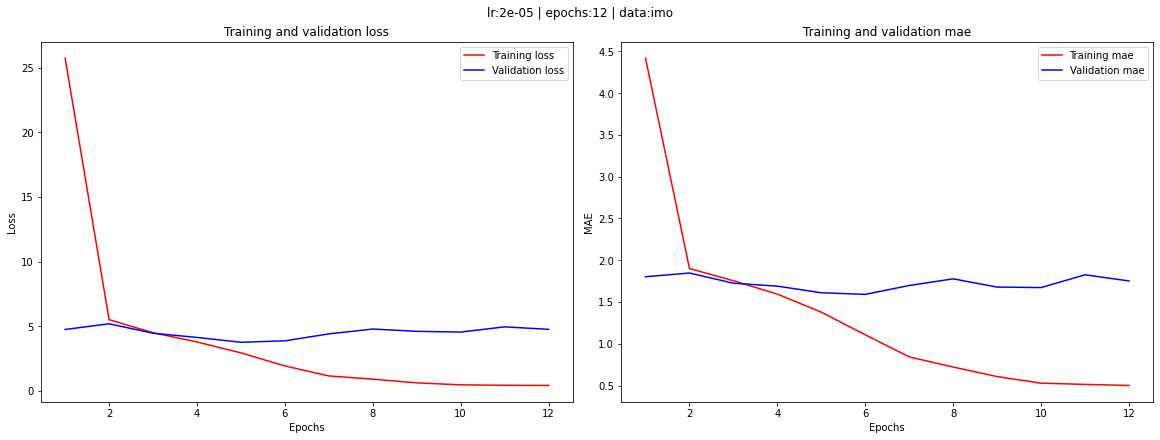

In [7]:
mathbert_regressor_model.plot_training_history_over_time()


In [8]:
# temp_path = "saved_models/regression/IMO-MATHBERT"
# mathbert_regressor_model.model.save(temp_path)


           actual              predict
Mean       5.16082575388927    6.072021484375
Variance   5.326022509214557    1.4940924644470215
STD        2.307817694102928    1.2223308086395264
min        0.980392156862745    3.2954773902893066
max        9.620282472794628    9.4718017578125

loss(mse)         rmse              mae               r2
7.794003237351    2.791774209594    2.370216059412    -0.463381580507


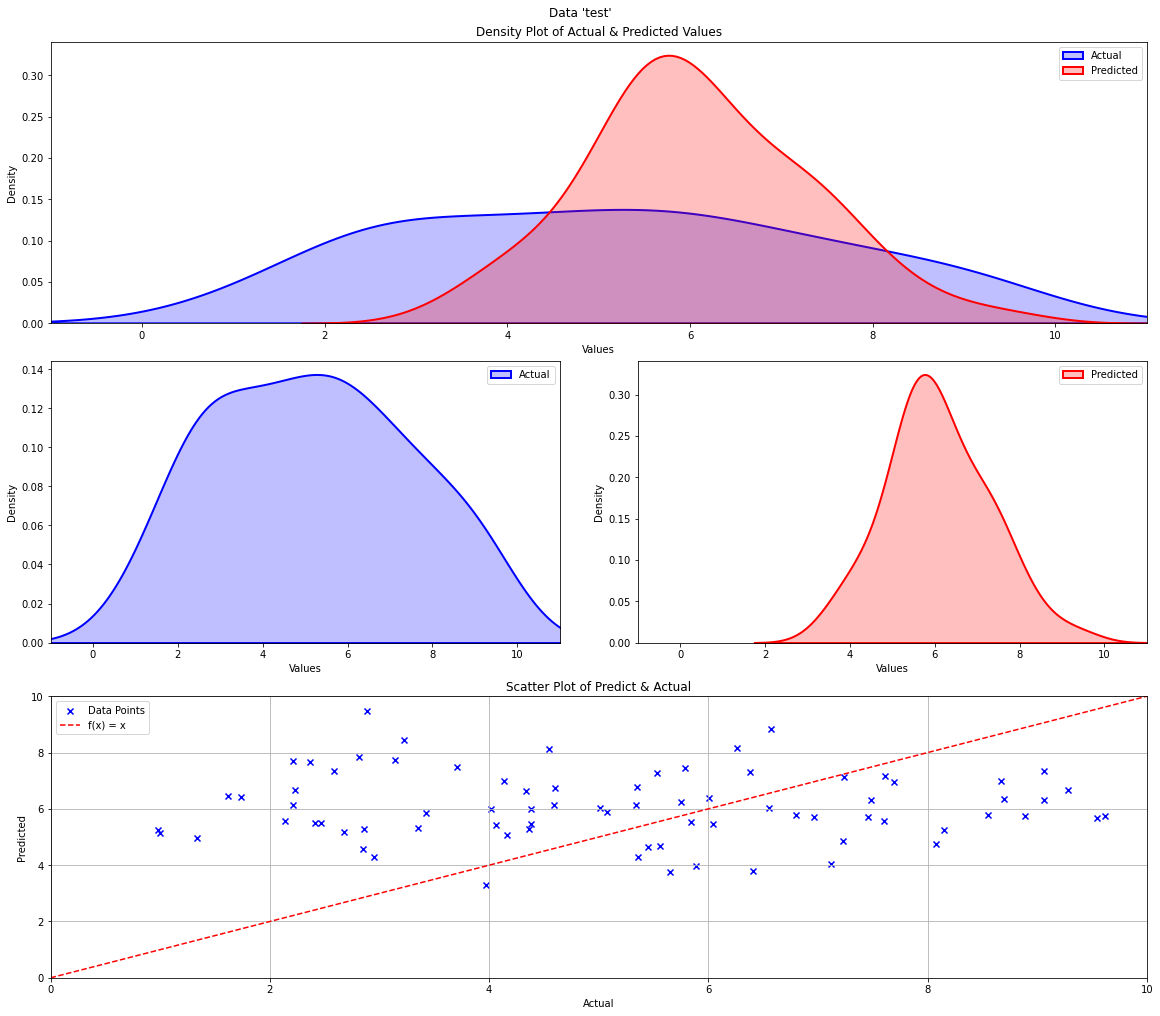

In [9]:
ds_type = 'test'
model_eval, stat_test, stat_pred = model_evaluate_and_analytics(mathbert_regressor_model.model, datasets_tokenized[ds_type]['X'], datasets_tokenized[ds_type]['y'], suptitle=ds_type)


In [10]:
compare_actual_and_predict_values(mathbert_regressor_model.model, datasets_tokenized[ds_type]['X'], datasets[ds_type]['X'], datasets_tokenized[ds_type]['y'])


 1. Let f be an injective function from {1,2,3, ldots} in itself. Prove that for any n we have: sum_{k=1}^{n} f(k)k^{-2} geq sum_{k=1}^{n} k^{-1}.
    Actual   Predicted
    1.616    6.448

 2. The diagonals AC and CE of the regular hexagon ABCDEF are divided by inner points M and N respectively, so that {AM over AC}={CN over CE}=r. Determine r if B,M and N are collinear.
    Actual   Predicted
    2.137    5.582

 3. Point A and segment BC are given. Determine the locus of points in space which are vertices of right angles with one side passing through A, and the other side intersecting segment BC.
    Actual   Predicted
    5.357    4.286

 4. Let k,m,n be natural numbers such that m+k+1 is a prime greater than n+1. Let c_s=s(s+1). Prove that (c_{m+1}-c_k)(c_{m+2}-c_k) ldots(c_{m+n}-c_k) is divisible by the product c_1c_2 ldots c_n.
    Actual   Predicted
    5.845    5.544

 5. Convex quadrilateral ABCD has angle ABC = angle CDA = 90^{ circ}. Point H is the foot of the perpendicular

,actual,predicted
0,1.616162,6.448224
1,2.136855,5.582246
2,5.357143,4.286104
3,5.844595,5.544025
4,9.278061,6.658181
5,4.062500,5.426819
6,4.341029,6.631975
7,3.424456,5.863343
8,1.000000,5.137245
9,6.383929,7.302692


In [11]:
splt = lambda array: '-'.join(map(str, [f"{i:.4f}" for i in array]))
data_type, batch_size, epochs, learning_rate, optimizer_type, training_time = data_type, batch_size, epochs, learning_rate, optimizer_type, mathbert_regressor_model.training_time
history_training_loss = splt(mathbert_regressor_model.history["loss"])
history_training_mae = splt(mathbert_regressor_model.history["mae"])
history_val_loss = splt(mathbert_regressor_model.history["val_loss"])
history_val_mae = splt(mathbert_regressor_model.history["val_mae"])

train_ = {
    'imo': {
        'mean': 5.86795670469622,
        'variance': 5.052634441745598,
        'std': 2.2478065845943234,
        'min': 0.5925925925925934,
        'max': 9.939605110336815
        },
    'combined_all': {
        'mean': 5.8744526592162085,
        'variance': 5.185485541802843,
        'std': 2.277166120818339,
        'min': 0.5925925925925934,
        'max': 9.942857142857145
        },
    }

temp = f"XX,regression,MATHBERT,{data_type},{batch_size},{epochs},{learning_rate},{optimizer_type},{training_time:.2f},{model_eval['model_eval']['mse']:.7f},{model_eval['model_eval']['rmse']:.7f},{model_eval['model_eval']['mae']:.7f},{model_eval['model_eval']['r2']:.7f},{trainable_l1},{trainable_l2},{trainable_l3},{trainable_l4},{trainable_l5},{trainable_l6},{trainable_l7},{trainable_l8},{trainable_l9},{trainable_l10},{trainable_l11},{trainable_l12},{history_training_loss},{history_val_loss},{history_training_mae},{history_val_mae},{stat_pred['pred']['mean']:.3f},{stat_pred['pred']['variance']:.3f},{stat_pred['pred']['std']:.3f},{stat_pred['pred']['min']:.3f},{stat_pred['pred']['max']:.3f}"
append_training_result(temp)


In [12]:
raise NameError("Error")

NameError: Error

### Reload model (compare actual & predict)

In [ ]:
# df = pd.read_csv("../data/regression/imo/test.csv")
# df.sort_values(by=['score'], inplace=True)
# df.reset_index(inplace=True)
# examples_texts = list(df['post_canonical'].values)
# tokenized_examples_texts = tokenize_text(examples_texts, max_length=512, return_tensor=False)
# examples_scores = df['score'].values

# reloaded_model = tf.saved_model.load('saved_models/regression/IMO-MATHBERT')
# compare_actual_and_predict_values(reloaded_model, tokenized_examples_texts, examples_texts, examples_scores)


## Example

In [ ]:
encoder = TFBertModel.from_pretrained("tbs17/MathBERT", from_pt=True)
tokenizer = AutoTokenizer.from_pretrained("tbs17/MathBERT", output_hidden_states=True)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [ ]:
encoder.config

BertConfig {
  "_name_or_path": "tbs17/MathBERT",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
tokenizer = BertTokenizer.from_pretrained('tbs17/MathBERT', output_hidden_states=True)
encoder = TFBertModel.from_pretrained("tbs17/MathBERT", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'bert.embeddings.position_ids', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [ ]:
example_text = "Determine all functions f : mathbb R to mathbb R satisfying the following two conditions: (a) f(x + y) + f(x - y) = 2f(x)f(y) for all x, y in mathbb R, and (b) lim_{x to infty} f(x) = 0."
encoded_inputs = tokenizer(example_text, return_tensors="tf", padding="max_length", max_length=512, truncation=True)

print(f"output keys                     -> {list(encoded_inputs.keys())}")
print(f"input_word_ids _ input_ids      -> {encoded_inputs['input_ids'][0, :12]}")
print(f"input_mask _ attention_mask     -> {encoded_inputs['attention_mask'][0, :12]}")
print(f"input_type_ids _ token_type_ids -> {encoded_inputs['token_type_ids'][0, :12]}")
print(f"shape: {encoded_inputs['attention_mask'].shape}\n")

# output = model(encoded_inputs)
# output

output keys                     -> ['input_ids', 'token_type_ids', 'attention_mask']
input_word_ids _ input_ids      -> [  101  5646  2035  4972  1042  1024  8785 10322  1054  2000  8785 10322]
input_mask _ attention_mask     -> [1 1 1 1 1 1 1 1 1 1 1 1]
input_type_ids _ token_type_ids -> [0 0 0 0 0 0 0 0 0 0 0 0]
shape: (1, 512)



In [ ]:
example_text = 'hElLO an bisa the aku'
encoded_inputs = tokenizer(example_text, return_tensors="tf", padding="max_length", max_length=12, truncation=True)

print(f"INPUT TEXT               --> '{example_text}'")
print(f"tokenize                 --> {tokenizer.tokenize(example_text)}")
print(f"decode                   --> {tokenizer.decode(encoded_inputs['input_ids'][0])}")
print(f"encode                   --> {tokenizer.encode(example_text)}")
print(f"convert_ids_to_tokens    --> {tokenizer.convert_ids_to_tokens([101, 7592, 2019, 20377, 2050, 1996, 17712, 2226, 102])}")
print(f"convert_tokens_to_ids    --> {tokenizer.convert_tokens_to_ids(['[CLS]', 'hello', 'an', 'bis', '##a', 'the', 'ak', '##u', '[SEP]'])}")
print(f"convert_tokens_to_string --> {tokenizer.convert_tokens_to_string(['hello', 'an', 'bis', '##a', 'the', 'ak', '##u'])}")

print()
print(f"cls_token : {tokenizer.cls_token}  - cls_token_id: {tokenizer.cls_token_id}")
print(f"mask_token: {tokenizer.mask_token} - mask_token_id: {tokenizer.mask_token_id}")
print(f"pad_token : {tokenizer.pad_token}  - pad_token_id: {tokenizer.pad_token_id} - pad_token_type_id: {tokenizer.pad_token_type_id}")
print(f"unk_token : {tokenizer.unk_token}  - unk_token_id: {tokenizer.unk_token_id}")
print(f"sep_token : {tokenizer.sep_token}  - sep_token_id: {tokenizer.sep_token_id}")
print()
print(f"all_special_ids             --> {tokenizer.all_special_ids}")
print(f"all_special_tokens          --> {tokenizer.all_special_tokens}")
print(f"all_special_tokens_extended --> {tokenizer.all_special_tokens_extended}")
print()
print(f"name_or_path              --> {tokenizer.name_or_path}")
print(f"vocab_size                --> {tokenizer.vocab_size}")
print(f"model_max_length          --> {tokenizer.model_max_length}")
print(f"model_input_names         --> {tokenizer.model_input_names}")
print(f"prepare_for_model         --> {tokenizer.prepare_for_model([101, 7592, 2019, 20377])}")

print(f"SPECIAL_TOKENS_ATTRIBUTES --> {tokenizer.SPECIAL_TOKENS_ATTRIBUTES}")


INPUT TEXT               --> 'hElLO an bisa the aku'
tokenize                 --> ['hello', 'an', 'bis', '##a', 'the', 'ak', '##u']
decode                   --> [CLS] hello an bisa the aku [SEP] [PAD] [PAD] [PAD]
encode                   --> [101, 7592, 2019, 20377, 2050, 1996, 17712, 2226, 102]
convert_ids_to_tokens    --> ['[CLS]', 'hello', 'an', 'bis', '##a', 'the', 'ak', '##u', '[SEP]']
convert_tokens_to_ids    --> [101, 7592, 2019, 20377, 2050, 1996, 17712, 2226, 102]
convert_tokens_to_string --> hello an bisa the aku

cls_token : [CLS]  - cls_token_id: 101
mask_token: [MASK] - mask_token_id: 103
pad_token : [PAD]  - pad_token_id: 0 - pad_token_type_id: 0
unk_token : [UNK]  - unk_token_id: 100
sep_token : [SEP]  - sep_token_id: 102

all_special_ids             --> [100, 102, 0, 101, 103]
all_special_tokens          --> ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
all_special_tokens_extended --> ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

name_or_path              --> tbs17/M